In [185]:
import pandas as pd
import plotly.express as px
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from deep_translator import GoogleTranslator

In [186]:
# To be parsed:
date_cols = {
    'olist_order_reviews_dataset.csv': ['review_creation_date', 'review_answer_timestamp']
}

In [187]:
def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    filename = os.path.basename(path)
    parse_dates = date_cols.get(filename, [])
    return pd.read_csv(path, parse_dates=parse_dates)

In [188]:
# Load the reviews dataset:
df_reviews = read_olist_csv("archive/olist_order_reviews_dataset.csv")
df_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47


| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `review_id`              | Unique identifier for each review.                                          |
| `order_id`               | Identifier linking the review to a specific order.                          |
| `review_score`           | Numerical score given by the customer (1 to 5, where 1 = worst, 5 = best).  |
| `review_comment_title`   | Optional short title provided by the customer in their review.              |
| `review_comment_message` | Optional detailed review message written by the customer.                   |
| `review_creation_date`   | Date when the customer submitted the review.                                |
| `review_answer_timestamp`| Date and time when the seller or platform responded to the review.          |

In [189]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


In [190]:
df_reviews.describe()

,review_score,review_creation_date,review_answer_timestamp
count,99224.000000,99224,99224
mean,4.086421,2018-01-12 20:49:23.948238336,2018-01-16 00:23:56.977938688
min,1.000000,2016-10-02 00:00:00,2016-10-07 18:32:28
25%,4.000000,2017-09-23 00:00:00,2017-09-27 01:53:27.249999872
50%,5.000000,2018-02-02 00:00:00,2018-02-04 22:41:47.500000
75%,5.000000,2018-05-16 00:00:00,2018-05-20 12:11:21.500000
max,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35
std,1.347579,NaN,NaN


In [191]:
summary = []

for col in df_reviews.columns:
    unique_vals = df_reviews[col].dropna().unique()
    summary.append({
        'Column': col,
        'Unique Count': len(unique_vals),
        'Unique Values': unique_vals
    })

df_summary = pd.DataFrame(summary)
df_summary

,Column,Unique Count,Unique Values
0,review_id,98410,"[7bc2406110b926393aa56f80a40eba40, 80e641a11e5..."
1,order_id,98673,"[73fc7af87114b39712e6da79b0a377eb, a548910a1c6..."
2,review_score,5,"[4, 5, 1, 3, 2]"
3,review_comment_title,4527,"[recomendo, Super recomendo, Não chegou meu pr..."
4,review_comment_message,36159,"[Recebi bem antes do prazo estipulado., Parabé..."
5,review_creation_date,636,"[2018-01-18 00:00:00, 2018-03-10 00:00:00, 201..."
6,review_answer_timestamp,98248,"[2018-01-18 21:46:59, 2018-03-11 03:05:13, 201..."


In [192]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In real-world reviews, it's very common for customers to:

- Write only a message and leave the title blank (most typical)
- Leave just a title (e.g., "Great!" or "Terrible!") without elaborating

But if both review_comment_title and review_comment_message are missing, then there's no actual comment—just a score. These are often not useful for text analysis or NLP.

In [193]:
# Count rows where both title and message are missing:
no_comment_count = df_reviews[
    df_reviews['review_comment_title'].isna() &
    df_reviews['review_comment_message'].isna()
].shape[0]

print(f"Rows with no title and no message: {no_comment_count}")

Rows with no title and no message: 56518


In [194]:
df_reviews.duplicated().sum()

0

In [195]:
# Calculate the difference in days between review creation and reply:
df_reviews['timestamp_diff'] = (
    df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']
).dt.days

# Check how many are negative:
negative_diff = df_reviews[df_reviews['timestamp_diff'] < 0]
print(f"Reviews where reply came before review: {len(negative_diff)}")

Reviews where reply came before review: 0


In [196]:
# Calculate time difference in days:
df_reviews['reply_delay_days'] = (
    df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']
).dt.total_seconds() / 86400

# Calculate average (exclude any negative or missing delays):
avg_reply_delay = df_reviews[df_reviews['reply_delay_days'] >= 0]['reply_delay_days'].mean()

print(f"Average reply time to customer reviews: {avg_reply_delay:.2f} days")

Average reply time to customer reviews: 3.15 days


In [197]:
# Filter reviews with low scores (1 to 3 stars):
low_reviews = df_reviews[df_reviews['review_score'].isin([1, 2, 3])]

In [198]:
# Remove rows where both comment title and message are NaN:
df_reviews = df_reviews[
    df_reviews['review_comment_title'].notna() |
    df_reviews['review_comment_message'].notna()
]

In [199]:
# Double check:
no_comment_count = df_reviews[
    df_reviews['review_comment_title'].isna() &
    df_reviews['review_comment_message'].isna()
].shape[0]

print(f"Rows with no title and no message: {no_comment_count}")

Rows with no title and no message: 0


In [200]:
# Combine comment title and message into a single column:
low_reviews['full_comment'] = (
    low_reviews['review_comment_title'].fillna('') + ' ' + 
    low_reviews['review_comment_message'].fillna('')
).str.strip()

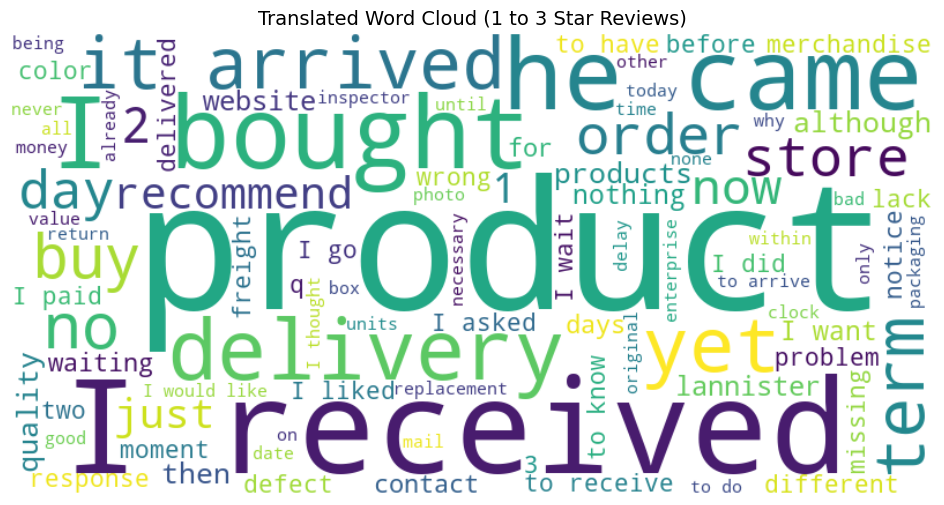

In [ ]:
# Prepare and clean text:
all_text = ' '.join(low_reviews['full_comment'].dropna().astype(str).tolist())
words = re.findall(r'\b\w+\b', all_text.lower())

# Load Portuguese and English stopwords:
stopwords_pt = set(stopwords.words('portuguese'))
stopwords_eng = set(stopwords.words('english'))
stop_words = stopwords_pt.union(stopwords_eng)

# Remove stopwords:
filtered_words = [word for word in words if word not in stop_words]

# Get 100 most common words:
common_words = Counter(filtered_words).most_common(100)

# Translate with cache:
translator = GoogleTranslator(source='pt', target='en')
cache = {}
translated_common_words = []

for word, count in common_words:
    try:
        if word not in cache:
            cache[word] = translator.translate(word)
        translated_common_words.append((cache[word], count))
    except Exception as e:
        translated_common_words.append((word, count))

# Create frequency dict for WordCloud:
translated_freq = dict(translated_common_words)

# Generate and display WordCloud:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(translated_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Translated Word Cloud (1-3 Star Reviews)", fontsize=14)
plt.show()

In [202]:
# Word frequency:
for word, count in translated_common_words:
    print(f"{word}: {count}")

product: 8561
I received: 4070
I bought: 2198
he came: 2168
delivery: 2092
yet: 1745
delivered: 1741
it arrived: 1612
term: 1431
no: 1242
buy: 1120
order: 995
store: 962
day: 897
2: 800
good: 760
now: 758
recommend: 748
1: 712
just: 688
products: 671
then: 667
although: 664
quality: 650
lannister: 617
website: 614
two: 593
nothing: 574
I want: 572
other: 530
waiting: 529
for: 525
contact: 521
days: 509
mail: 496
notice: 461
I liked: 455
I did: 435
problem: 432
different: 424
wrong: 421
good: 420
moment: 419
two: 404
to have: 403
I paid: 402
q: 401
3: 395
to receive: 391
I wait: 384
defect: 381
color: 379
I asked: 374
response: 360
lack: 351
before: 349
merchandise: 346
freight: 345
missing: 343
I go: 342
return: 338
delivered: 332
to know: 331
replacement: 330
enterprise: 326
money: 326
inspector: 324
photo: 321
only: 317
good: 316
today: 302
I would like: 301
return: 300
delay: 296
bad: 295
value: 293
box: 283
other: 278
within: 276
I thought: 276
date: 270
packaging: 264
delay: 263
c

## Univariate Analysis

In [204]:
# Review score distribution:
fig = px.histogram(
    df_reviews,
    x='review_score',
    title='Review Score Distribution',
    color='review_score',
    category_orders={'review_score': [1, 2, 3, 4, 5]},
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.show()

In [205]:
# Comment length:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)

fig = px.histogram(
    df_reviews,
    x='comment_length',
    nbins=50,
    title='Length of Review Comments'
)
fig.show()

## Bivariate Analysis

In [206]:
# Review score vs comment length:
fig = px.box(
    df_reviews,
    x='review_score',
    y='comment_length',
    title='Comment Length by Review Score',
    color='review_score'
)
fig.show()

In [207]:
# Review score over time:
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])

fig = px.box(
    df_reviews,
    x=df_reviews['review_creation_date'].dt.month,
    y='review_score',
    title='Monthly Review Score Distribution',
    labels={'x': 'Month'}
)
fig.show()

In [213]:
# Make sure comment length and month are already computed:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)
df_reviews['month'] = pd.to_datetime(df_reviews['review_creation_date']).dt.to_period("M").astype(str)

# Count reviews per score per month:
low_score_summary = (
    df_reviews[df_reviews['review_score'].isin([1, 2, 3])]
    .groupby(['month', 'review_score'])
    .agg(count=('review_id', 'count'))
    .reset_index()
)

# Pivot to wide format:
highlight_table = low_score_summary.pivot(index='month', columns='review_score', values='count').fillna(0)

# Add a total low score column:
highlight_table['total_low_reviews'] = highlight_table.sum(axis=1)

# Sort by total_low_reviews:
highlight_table = highlight_table.sort_values(by='total_low_reviews', ascending=False)

In [ ]:
# Display the top 10 months with the most low score reviews:
top_low_score_months = highlight_table.head(10)
top_low_score_months

review_score,1,2,3,total_low_reviews
month,,,,
2018-03,1139.0,204.0,317.0,1660.0
2017-12,892.0,185.0,280.0,1357.0
2018-04,836.0,182.0,269.0,1287.0
2018-08,675.0,185.0,317.0,1177.0
2018-02,609.0,142.0,263.0,1014.0
2018-05,574.0,147.0,255.0,976.0
2018-01,548.0,145.0,240.0,933.0
2018-06,505.0,151.0,256.0,912.0
2018-07,381.0,96.0,188.0,665.0


In [218]:
# Prepare data for highlighting:
highlight_plot_data = low_score_summary.copy()
highlight_plot_data['review_score'] = highlight_plot_data['review_score'].astype(str)

fig = px.bar(
    highlight_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Low Review Score Distribution by Month (1-3 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()